##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('Data/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('Data/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


## Work for task 1
In order to print out the rows of the dataframe values, we can either slice the dataframe directly or we can slice out the dataframe values array 

In [7]:
df[0:5]

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [8]:
df.values[0:5]

array([[-115.087518  ,   36.216702  ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ],
       [-115.2401715 ,   36.189693  ,    1.        ,    1.        ,
           1.        ,    1.        ,    0.        ],
       [-115.14308839,   36.18132889,    2.        ,    1.        ,
           2.        ,    0.        ,    1.        ],
       [-115.22501367,   36.1176334 ,    3.        ,    1.        ,
           1.        ,    2.        ,    2.        ],
       [-115.176708  ,   36.095967  ,    4.        ,    1.        ,
           1.        ,    3.        ,    0.        ]])

In each columns, we have the data for a specific crime that was reported to the Las Vegas Metropolitan Police Departments. Those data include the Longitude or X(first column), Latitude or Y(second column), Area of Command which is converted into int instead from starting from zero(third column), NIBRS Offense Code which is also converted into int starting from zero(fourth column), Day of week (fifth column, converted as well), Time which is represented in the hour of the day(sixth column), and lastly the victim count(last column).

The input data that we will be using for this model will be the data from the first to the sixth column. The victim count which is the data in the last column will be our output of the model since it is what we are trying to predict.

To find the range of values in each column we can use the max and min on each column of the df values

The range of value of the longitude column can be found by the below code.

In [9]:
longitude_max = max(df.values[:, 0])
longitude_min = min(df.values[:,0])
longitude_max, longitude_min

(-114.6255705, -116.0)

The range of value of latitude column can be found by the below code.

In [10]:
latitude_max = max(df.values[:, 1])
latitude_min = min(df.values[:,1])
latitude_max, latitude_min

(37.0000000000001, 35.0684190000001)

The range of value of the Area of Command column can be found by the below code.

In [11]:
AOC_max = max(df.values[:, 2])
AOC_min = min(df.values[:,2])
AOC_max, AOC_min

(11.0, 0.0)

The range of value of the NIBRS Offense Code column can be found by the below code.

In [12]:
NOC_max = max(df.values[:, 3])
NOC_min = min(df.values[:,3])
NOC_max, NOC_min

(2.0, 0.0)

The range of value of the Day of the Week column can be found by the below code.

In [13]:
DOW_max = max(df.values[:, 4])
DOW_min = min(df.values[:,4])
DOW_max, DOW_min

(6.0, 0.0)

The range of value of the Time column can be found by the below code.

In [14]:
Time_max = max(df.values[:, 5])
Time_min = min(df.values[:,5])
Time_max, Time_min

(23.0, 0.0)

The range of value of the Number of victim column can be found by the below code.

In [15]:
NoVictim_max = max(df.values[:, 6])
NoVictim_min = min(df.values[:,6])
NoVictim_max, NoVictim_min

(6.0, 0.0)

From the range that we obtained from each column, we can see that only the latitude and longitude values may need to be normalized due to the fact that they both are significantly larger number than the number in the other column which might make it more difficult for the model to adjust the weight and bias since the output that we expect are int value from 0 to 6.

One way of normalizing the data is using the min-max normalization. The min-max normalization within a range of [a,b] can be done by the following formula.

$x_{\text{norm}}$ = $a + \frac{(x-x_{\text{min})}(b-a)}{{x_{\text{max}}-x_{\text{min}}}}$

Let set our range from 0 to 10 for the range of longitude and latitude normalization scale. Using the above formula we can scale our longitude and latitude accordingly.

In [16]:
df['X'] = ((df['X']-df['X'].min())*10)/(df['X'].max()-df['X'].min())

To verify the result, we can print out the longitude data, and the min-max value after the normalization.

In [17]:
df['X']

0      6.638987
1      5.528319
2      6.234671
3      5.638604
4      5.990064
         ...   
270    6.440938
271    6.688131
272    6.023787
273    6.165521
274    6.836695
Name: X, Length: 275, dtype: float64

In [18]:
[df['X'].min(), df['X'].max()]

[0.0, 10.0]

Repeat the same process for the latitude.

In [19]:
df['Y'] = ((df['Y']-df['Y'].min())*10)/(df['Y'].max()-df['Y'].min())

In [20]:
df['Y']

0      5.944783
1      5.804955
2      5.761653
3      5.431894
4      5.319725
         ...   
270    5.442034
271    5.664940
272    5.459740
273    5.164962
274    5.533688
Name: Y, Length: 275, dtype: float64

In [21]:
[df['Y'].min(), df['Y'].max()]

[0.0, 10.0]

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

## Work for Task 2

In order to create a dataset object we need to 2 tensor for the input and output. Therefore, we need to create the two tensor object from the dataframe values array.

In [22]:
input_tensor = torch.tensor(df.values[:,0:6])

In [23]:
output_tensor = torch.tensor(df.values[:,6:7])

In [24]:
dataset = TensorDataset(input_tensor, output_tensor)

In order to split the data into training and testing data, we can use random_split function from torch library. In this case, we will split the data into a 80% training data and 20% testing data. However, the random_split function take the length of the two resulting tensor as input instead of percentage, therefore we will need to calculate the length of 80% of our dataset and the rest of will be the other 20%.

In [25]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

In [26]:
train_data, test_data = random_split(dataset, [train_size, test_size])

In [27]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=20)
test_loader = DataLoader(test_data, shuffle=False, batch_size=20)

In [28]:
train_size

220

## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

## Work for Task 3

In [29]:
import torch.nn as nn

We can create a NeuralNetwork class for this model with 3 activation layer and 2 hidden layer by inheriting the nn.Module class. For this model we will use ReLU as our activation functions since the output will be one continous values.

In [30]:
class NNModel(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(NNModel, self).__init__()
        self.activation1 = nn.ReLU()
        self.activation2 = nn.ReLU()
        self.activation3 = nn.ReLU()

        self.layer1 = nn.Linear(inputDim, hiddenDim)
        self.layer2 = nn.Linear(hiddenDim, hiddenDim)
        self.layer3 = nn.Linear(hiddenDim, outputDim)

    def forward(self, x):
        ffw1 = self.activation1(self.layer1(x))
        ffw2 = self.activation2(self.layer2(ffw1))
        output = self.activation3(self.layer3(ffw2))
        return output

Our model will have 6 inputs and 1 output.

In [31]:
model = NNModel(6, 10, 1)

In [32]:
model

NNModel(
  (activation1): ReLU()
  (activation2): ReLU()
  (activation3): ReLU()
  (layer1): Linear(in_features=6, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

For this model we will use mean square error as our loss function since the output is a continous value. We will also use Adam as our optimizer with a learning rate of 0.01.

In [33]:
loss_function = nn.MSELoss()

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
num_epoch = 20
iter = 0
for epoch in range(num_epoch):
    for num, (inputs, victim_nums) in enumerate(train_loader):
        inputs = inputs.requires_grad_()
        optimizer.zero_grad()
        predictions = model(inputs.float())
        loss = loss_function(predictions, victim_nums.float())
        loss.backward()
        optimizer.step()
    iter+=1
    total_loss = 0
    for i, (inputs, victim_nums) in enumerate(test_loader):
        inputs = inputs.requires_grad_()
        predictions = model(inputs.float())
        loss = loss_function(predictions, victim_nums.float())
        total_loss +=loss
    average_loss = total_loss/(test_size/20)
    print("Average test loss after epoch {}: {}".format(iter, average_loss))
        
    

Average test loss after epoch 1: 1.199058175086975
Average test loss after epoch 2: 1.2227447032928467
Average test loss after epoch 3: 1.1966651678085327
Average test loss after epoch 4: 1.181410551071167
Average test loss after epoch 5: 1.2107067108154297
Average test loss after epoch 6: 1.163202166557312
Average test loss after epoch 7: 1.1584845781326294
Average test loss after epoch 8: 1.1582460403442383
Average test loss after epoch 9: 1.1671065092086792
Average test loss after epoch 10: 1.1563689708709717
Average test loss after epoch 11: 1.1515902280807495
Average test loss after epoch 12: 1.1439495086669922
Average test loss after epoch 13: 1.2084457874298096
Average test loss after epoch 14: 1.1722474098205566
Average test loss after epoch 15: 1.121559739112854
Average test loss after epoch 16: 1.1569583415985107
Average test loss after epoch 17: 1.1660887002944946
Average test loss after epoch 18: 1.135208249092102
Average test loss after epoch 19: 1.101794958114624
Average 

In [36]:
for i, example in enumerate(test_loader):
    x, y = example
    break

In [37]:
model(x.float())

tensor([[0.8403],
        [1.1620],
        [0.3798],
        [1.2427],
        [0.8741],
        [1.1620],
        [0.5369],
        [0.6273],
        [0.5484],
        [1.0794],
        [0.7901],
        [0.8974],
        [0.6808],
        [0.4529],
        [1.1585],
        [1.2543],
        [1.2100],
        [0.6812],
        [1.0195],
        [1.2999]], grad_fn=<ReluBackward0>)

In [38]:
y

tensor([[1.],
        [3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64)

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

## Work for Task 4

Since there are at most 6 victims and at least 0 victims, we can create 7 classes, 1 for each number from 0 to 6. Let's define a neural network class model for the classification problem. In this model, we will have 4 activation layers and 5 hidden layers. Each layer will be activated by a Sigmoid function since it is a classification model.

In [39]:
class NNClassModel(nn.Module):
    def __init__(self, inputdim, hiddendim, outputdim):
        super(NNClassModel, self).__init__()
        self.layer1 = nn.Linear(inputdim, hiddendim)
        self.layer2 = nn.Linear(hiddendim, hiddendim)
        self.layer3 = nn.Linear(hiddendim, hiddendim)
        self.layer4 = nn.Linear(hiddendim, outputdim)
        self.activation1 = nn.Sigmoid()
        self.activation2 = nn.Sigmoid()
        self.activation3 = nn.Sigmoid()
        self.activation4 = nn.Sigmoid()
    def forward(self, x):
        ffw1 = self.activation1(self.layer1(x))
        ffw2 = self.activation2(self.layer2(ffw1))
        ffw3 = self.activation3(self.layer3(ffw2))
        output = self.activation4(self.layer4(ffw3))
        return output

We can find the class based on the victim numbers on our dataset. We found out from earlier that our victim numbers data has a max of 6 and a min of 0. Since the number of victim is discrete, there should be a total of 7 class ranging from 0 to 6.

We'll have the number of hidden dimension in each layer 42 since it provide the best accuracy overall among all the amount that were tested.

In [40]:
class_model = NNClassModel(6, 42, 7)

We will use cross entropy loss as our loss function for this model since it is a classification model. We will keep using Adam as our optimizer.

In [41]:
class_loss_function = nn.CrossEntropyLoss()

In [42]:
optimizer = torch.optim.Adam(class_model.parameters(), lr = 0.001)

This training loop code is based on the training loop example from the PyTorch official document.

In [43]:
def train_one_epoch():
    avg_train_loss = 0.
    last_loss = 0.
    for i, data in enumerate(train_loader):
        inputs, victim_nums = data
        victim_nums = victim_nums.long().squeeze()
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = class_model(inputs)
        loss = class_loss_function(outputs, victim_nums)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        print('  batch {} loss: {}'.format(i + 1, running_loss))
        last_loss += running_loss
    avg_train_loss = last_loss / (i+1)
    return avg_train_loss

In [44]:
epoch_number = 0

EPOCHS = 50

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    class_model.train(True)
    avg_train_loss = train_one_epoch()


    running_test_loss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    class_model.eval()
    correct = 0
    total = 0
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):
            test_inputs, test_victim_nums = test_data
            test_victim_nums = test_victim_nums.long().squeeze()
            test_inputs = test_inputs.float()
            test_outputs = class_model(test_inputs)
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_victim_nums.size(0)
            # Total correct predictions
            correct += (predicted == test_victim_nums).sum()
            # print("victim number {}".format(total))
            # print("Correct {}".format(correct))
            test_loss = class_loss_function(test_outputs, test_victim_nums)
            running_test_loss += test_loss

    accuracy = 100 * correct / total
    avg_test_loss = running_test_loss / (i + 1)
    print('LOSS train {} test {}'.format(avg_train_loss, avg_test_loss))
    print('Total {} Correct {} Accuracy {}'.format(total, correct, accuracy))
    epoch_number += 1

EPOCH 1:
  batch 1 loss: 1.867525339126587
  batch 2 loss: 1.8440049886703491
  batch 3 loss: 1.8244550228118896
  batch 4 loss: 1.844646692276001
  batch 5 loss: 1.8459007740020752
  batch 6 loss: 1.8330751657485962
  batch 7 loss: 1.8200794458389282
  batch 8 loss: 1.8119351863861084
  batch 9 loss: 1.7955176830291748
  batch 10 loss: 1.7753467559814453
  batch 11 loss: 1.780525803565979
LOSS train 1.8220920779488303 test 1.7915037870407104
Total 55 Correct 16 Accuracy 29.090909957885742
EPOCH 2:
  batch 1 loss: 1.7555691003799438
  batch 2 loss: 1.8014070987701416
  batch 3 loss: 1.760859489440918
  batch 4 loss: 1.7541701793670654
  batch 5 loss: 1.7092745304107666
  batch 6 loss: 1.7581532001495361
  batch 7 loss: 1.7748768329620361
  batch 8 loss: 1.746148705482483
  batch 9 loss: 1.687949538230896
  batch 10 loss: 1.7321685552597046
  batch 11 loss: 1.6796518564224243
LOSS train 1.7418390078978105 test 1.7224678993225098
Total 55 Correct 16 Accuracy 29.090909957885742
EPOCH 3:
 

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

## Work for Task 5

From working with both model, task 3 is less challenging since we only have to calculate the loss after each epoch. Task 4 is a little bit more challenging, since we have to both minimize the loss as well as get a better accuracy. However, the output of the regression model from task 3 does not work very well with the result that we are trying to predict. One thing is that a person is a whole and it is impossible to have a decimal places amount of person. Although we can round the number, it does not work very well with this kind of task since the regression model use mean square error as its loss function. Assuming that we have data that are very bias in which most of the outcome is 0, eventhough we might come across the case in which there is a large amount of victims, the model will only update the parameter to minimize the mean square different. As a result, it will not work very well. On the other hand, treating this as a classification problems is better since the output of our model can be treated probability of the victims amount. As long as we have the right class number of victims, we can predict the amount of victims based on the class that has the highest probability. However, this model is limited to the amount of vicitims classes that we defined which mean it will not be able to predict the amount of victims that is higher than the amount of output classes that we predefined for the model. Overall, with the data that we have, the classification model work better than the regression one.

In [45]:
for i, example in enumerate(test_loader):
    x, y = example
    break

In [46]:
index = 15

In [47]:
output = class_model(x[index].float())

In [48]:
_, predicted = torch.max(output.data, 0)

In [49]:
predicted

tensor(0)

In [50]:
y[index]

tensor([1.], dtype=torch.float64)

Text(0.5, 1.0, 'Model output victim number 0\n Actual victim number 1')

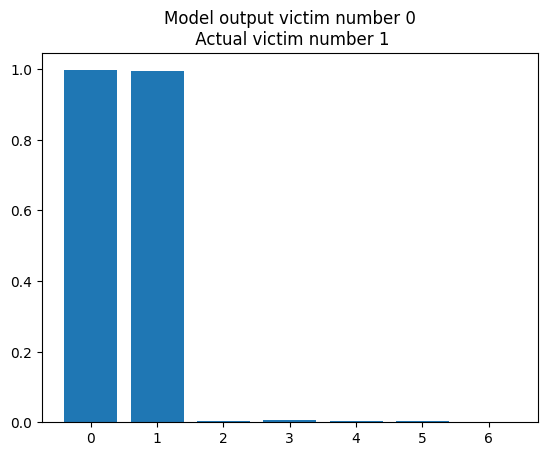

In [51]:
ax = plt.subplot()
ax.bar(range(7),output.detach().numpy())
ax.set_xticks(range(7))
plt.title("Model output victim number {}\n Actual victim number {}".format(predicted.item(), int(y[index].item())))


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


## Work for Task 6

In [52]:
df2 = pd.read_csv('Data/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

In [53]:
X = df2['X'].values
Y = df2['Y'].values
Z = df.values[:,4]



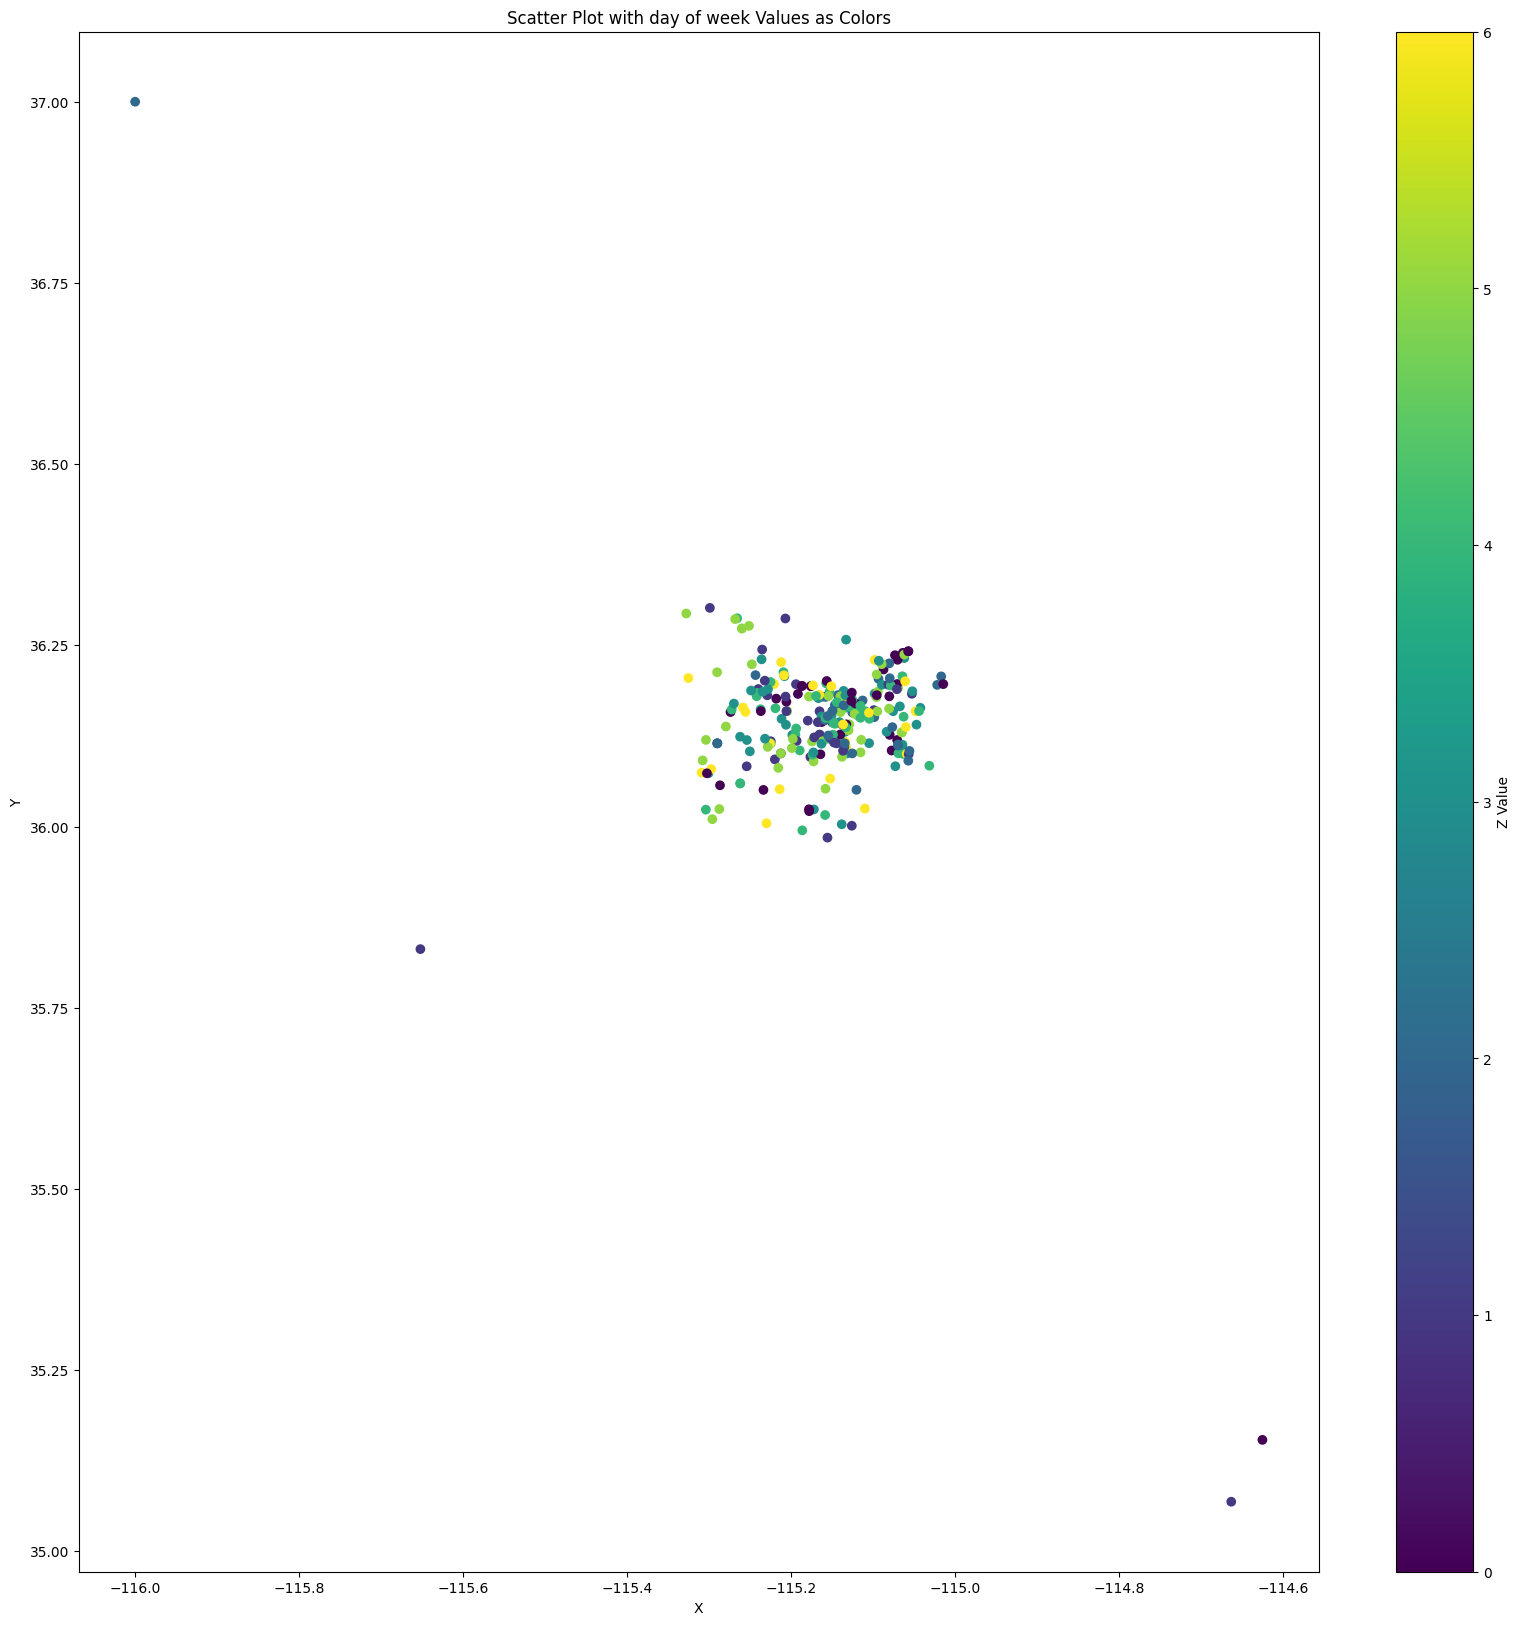

In [54]:
plt.figure(figsize=(20, 20))
scatter = plt.scatter(X, Y, c=Z, cmap='viridis')
plt.colorbar(scatter, label='Z Value')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with day of week Values as Colors')
plt.show()

From the raw data, we can see that crimes that happened on the early week day concentrated more on a particular area, whereas crimes that happened on the weekend happened all around the city. One reason of this might be because people are going out more all over the city on the weekend than during the week day where people mostly only go to work.

In [55]:
Z = df.values[:,6]

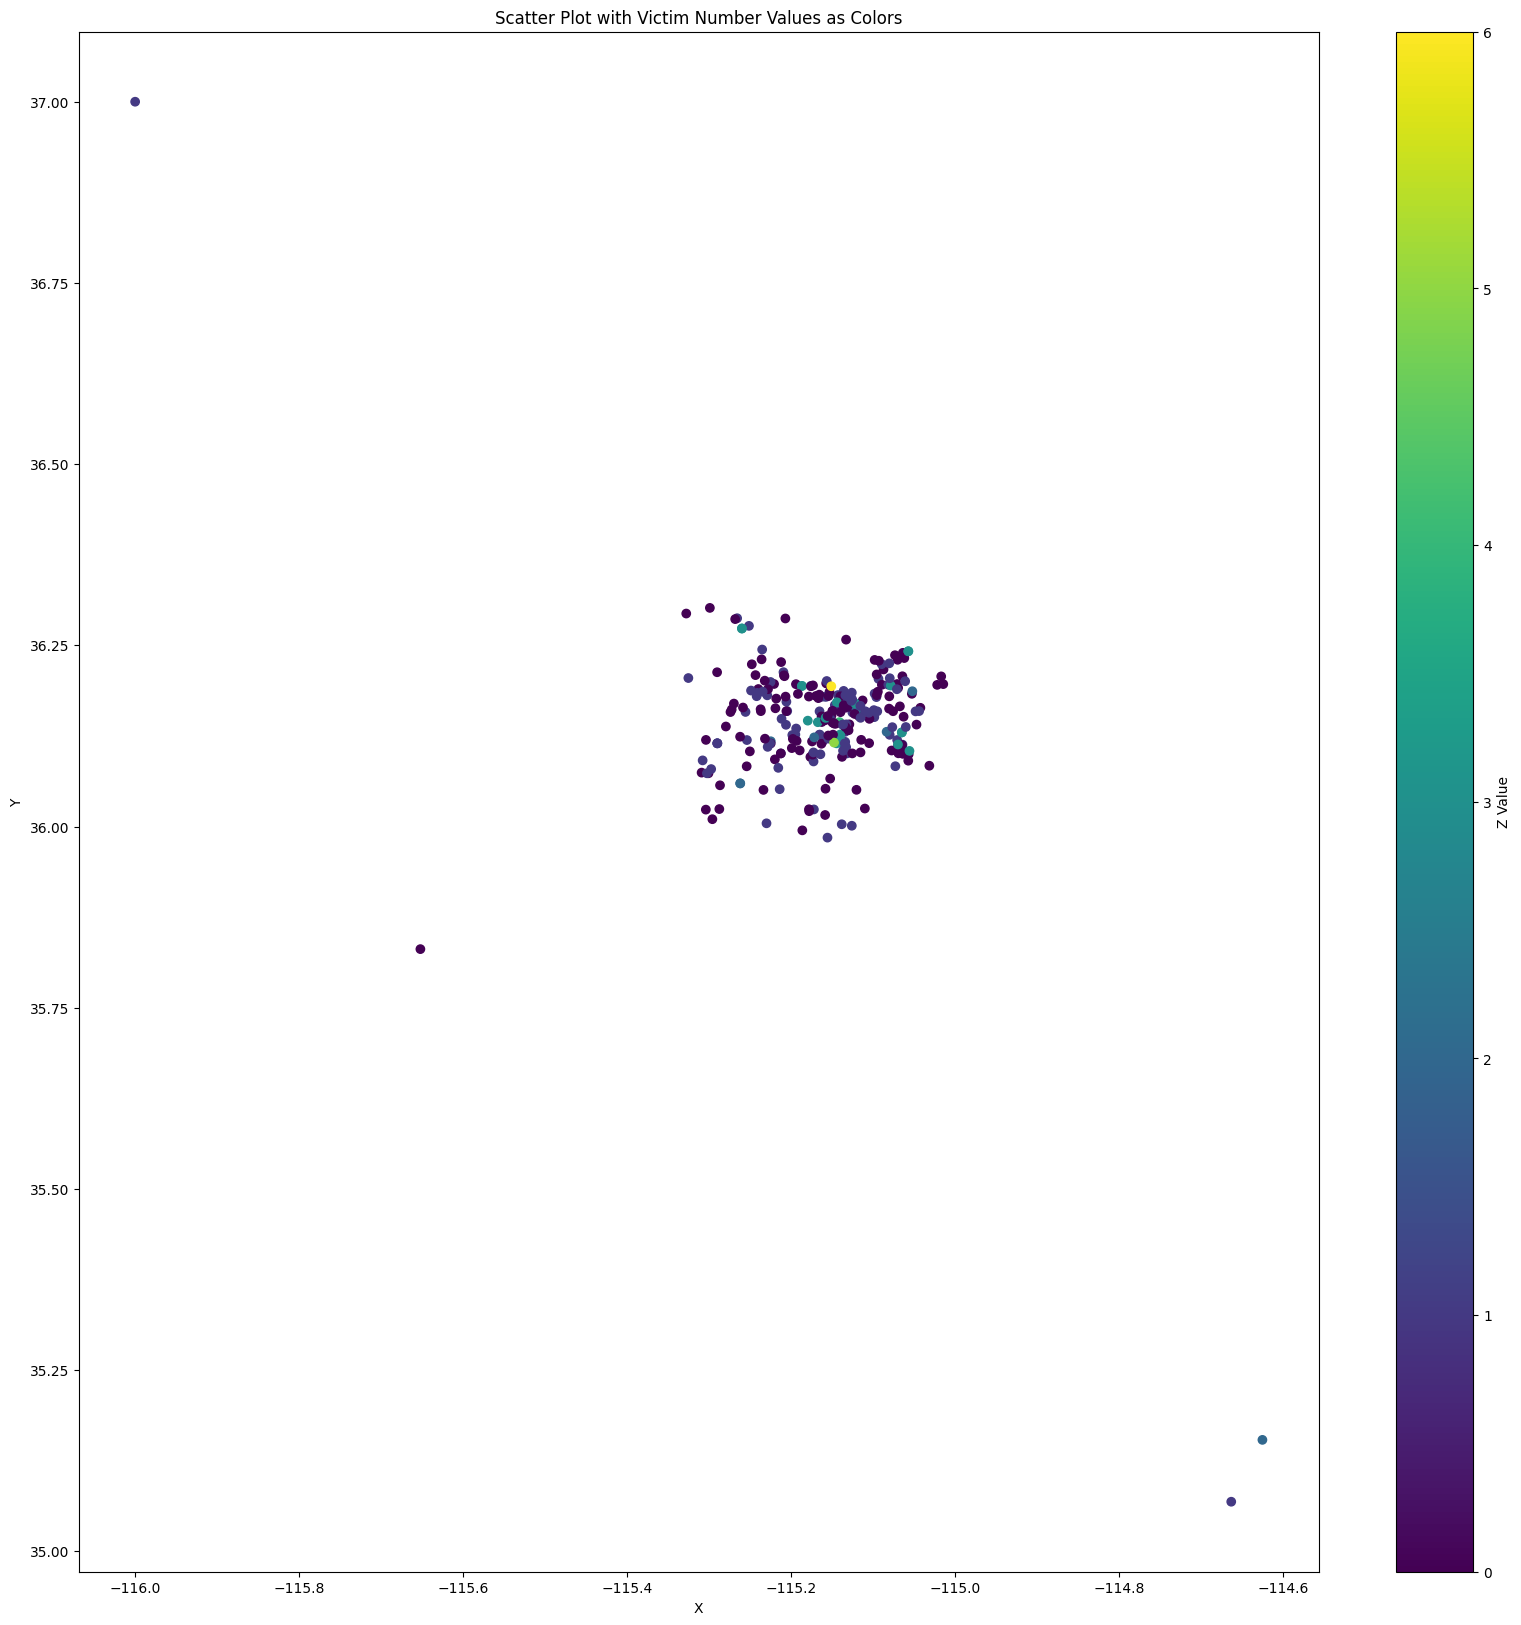

In [56]:
plt.figure(figsize=(20, 20))
scatter = plt.scatter(X, Y, c=Z, cmap='viridis')
plt.colorbar(scatter, label='Z Value')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Victim Number Values as Colors')
plt.show()

From this scatter plot, we can see that most of the crimes that happened all over the city involved 2 victims or less. Crimes that involved 3 people or more concentrated more on the upper right. There could be various reasons that can be drawn out from this data. One reason might be because those area might be more crowded or popular than other area. Another reason might also be because those area is not enforced very well by law enforcement. However, with just this data, we cannot make a direct conclusion that these reasons might be the case. More information is needed to draw a better and more precise reason of why this might be the case.

In [57]:
days, crimes_count = np.unique(df.values[:,4], return_counts=True)

In [69]:
days

array([0., 1., 2., 3., 4., 5., 6.])

In [61]:
crimes_count

array([40, 37, 32, 44, 51, 43, 28])

In [66]:
dataset = pd.DataFrame({ "DayOfWeek":days, "CrimesCount": crimes_count})

In [67]:
dataset

,DayOfWeek,CrimesCount
0,0.0,40
1,1.0,37
2,2.0,32
3,3.0,44
4,4.0,51
5,5.0,43
6,6.0,28


In [71]:
dataset.sort_values(by=['CrimesCount'])

,DayOfWeek,CrimesCount
6,6.0,28
2,2.0,32
1,1.0,37
0,0.0,40
5,5.0,43
3,3.0,44
4,4.0,51


According to the data, Friday has the most reported amount of crime.